# Urban canyon simulation plots [Section VI.B]
This example includes the scripts for the generation of plots relative to the street canyon simulations.

The first section plots ETCs resulting from different simulation/scattering implementations (see [``VIB1_street_canyon_decay.ipynb``](VIB1_street_canyon_decay.ipynb)).

The second section includes plots relative to the computational performance of the simulation (see [``VIB2_street_canyon_performance.ipynb``](VIB2_street_canyon_performance.ipynb)).

![alt text](figures/urban_canyon.svg "Illustration of the street canyon")

In [91]:
import matplotlib.pyplot as plt
import os
import numpy as np
import json
import pyfar as pf
from utils.fig_formatting import create_fig, export_fig
import csv
%matplotlib inline

Select data origin (same as paper or user-generated)

In [92]:
###################################################
#### SET "True" TO LOAD YOUR OWN GENERATED DATA
#### "False" TO LOAD THE DATA FROM THE PAPER
self_data=False
###################################################

if self_data:
    sub_dir="user"
else:
    sub_dir="paper"

basepath = os.path.join(os.getcwd(),"resources")

## ETC comparison in the street canyon

Load sparrowpy ETC data

In [93]:
# change the name of the file to load results with different patch sizes
sparrow_ETCs = pf.io.read(os.path.join(basepath,sub_dir,"ETCs_psize3.far"))

# sparrowpy ETCs
BSC_based=sparrow_ETCs["custom_etc"][0]
RISC_based = sparrow_ETCs["diffuse_etc"][0]
freq=sparrow_ETCs["freqs"]

Load RAVEN (ray-tracing) ETC data

In [94]:
# load raw data form RAVEN's output file
f=[]
ffile = os.path.join(basepath,"paper","raven_streetcanyon_retro.csv")
with open(ffile, mode ='r')as file:
  csvFile = csv.reader(file)
  for lines in csvFile:
        f.append(lines)

  g = np.array(f,dtype=np.float64)

# discern and normalize data
ffreq=g[0]
ttime = g[1:,0]
data = g[1:,1:].T/(4*np.pi)

# organise ETCs into pyfar TimeData object
ddata=np.empty((freq.shape[0],data.shape[-1]))
for i,f in enumerate(freq):
    ddata[i] = data[np.where(ffreq==f)[0]]
raven = pf.TimeData(data=ddata,times=ttime)

### nice big plot

Select frequency band to plot

In [95]:
# change this variable to check different frequency bands
freq_bin = 4e3
##

i = np.argmin(np.abs(freq-freq_bin))

C:\Users\jotag\AppData\Local\Temp\ipykernel_13144\992984300.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axin.set_xticklabels([""])
C:\Users\jotag\AppData\Local\Temp\ipykernel_13144\992984300.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axin.set_yticklabels([""])
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


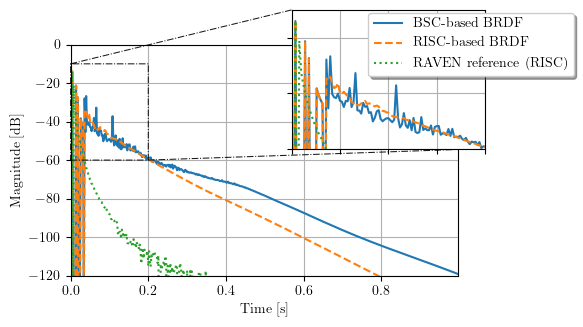

In [96]:
f,a=create_fig(figtype="big")
# main plot
pf.plot.time(BSC_based[i], dB=True, log_prefix=10,
             label=["BSC-based BRDF"],
             linestyle="-")
pf.plot.time(RISC_based[i], dB=True, log_prefix=10,
             label=["RISC-based BRDF"],
             linestyle="--")
pf.plot.time(raven[i], dB=True, log_prefix=10,
             label=["RAVEN reference (RISC)"],
             linestyle=":")
plt.legend(fontsize=10,loc="center left",bbox_to_anchor=(.75, 1 ),shadow=True)
plt.xlabel("Time  [s]")
plt.ylabel("Magnitude [dB]")
plt.ylim([-120,0])


# zoomed section
axin = a.inset_axes([0.57, 0.55, 0.5, 0.6])
axin.grid()
pf.plot.time(BSC_based[i], dB=True, log_prefix=10,
             label=["BSC-based BRDF"],
             linestyle="-",ax=axin)
pf.plot.time(RISC_based[i], dB=True, log_prefix=10,
             label=["RISC-based BRDF"],
             linestyle="--",ax=axin)
pf.plot.time(raven[i], dB=True, log_prefix=10,
             label=["RAVEN reference (RISC)"],
             linestyle=":",ax=axin)
axin.set_xlim(0,.2)
axin.set_ylim(-60,-10)
axin.set_xlabel("")
axin.set_ylabel("")
axin.set_xticklabels([""])
axin.set_yticklabels([""])
a.indicate_inset_zoom(axin,edgecolor='k',linestyle='-.',alpha=.9,linewidth=.75)

export_fig(f,filename="Figure12",fformat=".eps")

## Computational performance

helpful labels

In [97]:
tlabel="run-time\,[s]"
mlabel="peak memory\,[MB]"
mlegend=["baking", "exchange","collection","baseline"]
tlegend=["baking", "exchange","collection","total", "baseline"]

load performance measurement file

In [98]:
with open(os.path.join(basepath,sub_dir,"street_canyon_perf.json")) as json_file:
    dat = json.load(json_file)

### ETC time resolution


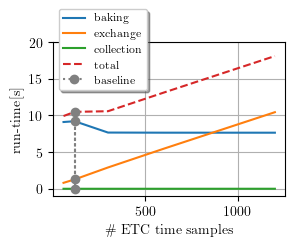

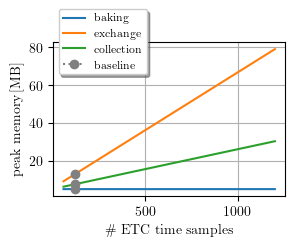

In [99]:
runtime = np.array(dat["time_step"]["t"])[:,1:]
data = np.array(dat["time_step"]["data"])
memory = np.array(dat["time_step"]["mem"])[:,1:,1]/1000**2

# get number of total samples
num = 1.2/data

# baseline
i = np.argwhere(data==dat["baseline"]["time_step"])[0]

 #runtime of all sections
ssum = np.sum(runtime,axis=1)

fn,a=create_fig()
plt.plot(num,runtime)
 #plot total
plt.plot(num,ssum,'--')
 #plot baseline
plt.plot(num[i]*np.ones((len(runtime.T[:,i])+1)),
         np.append(runtime.T[:,i],ssum[i]),
         'o:', color='gray')
plt.xlabel("\\# ETC time samples")
plt.ylabel(tlabel)
plt.legend(tlegend,fontsize=8,loc="upper left",
           bbox_to_anchor=(0, 1.25),shadow=True)
plt.ylim([-1,20])
plt.show()

export_fig(fn,filename="Figure13a")


fmn,a=create_fig()
plt.plot(num,memory)
# plot baseline
plt.plot(num[i]*np.ones_like(memory.T[:,i]),memory.T[:,i],
         'o:', color='gray')
plt.xlabel("\\# ETC time samples")
plt.ylabel(mlabel)
plt.legend(mlegend,fontsize=8,loc="upper left",
           bbox_to_anchor=(0, 1.25),shadow=True)
plt.show()

export_fig(fmn,filename="Figure13b")

### BRDF resolution

C:\Users\jotag\AppData\Local\Temp\ipykernel_13144\2724170475.py:8: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.gaussian.'
  samples = pf.samplings.sph_gaussian(dd)
c:\Users\jotag\Documents\dev\sparapy\.venv\Lib\site-packages\pyfar\samplings\samplings.py:344: PyfarDeprecationWarning: 'This function will be changed in pyfar 0.8.0 to init(x, y, z).'
  sampling = pyfar.Coordinates(
c:\Users\jotag\Documents\dev\sparapy\.venv\Lib\site-packages\pyfar\classes\coordinates.py:276: PyfarDeprecationWarning: 'This function will be deprecated in pyfar 0.8.0 in favor of spharpy.samplings.SamplingSphere.'
  self.sh_order = sh_order


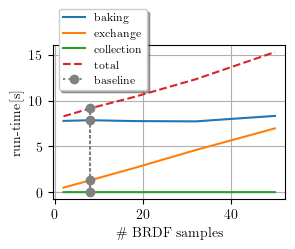

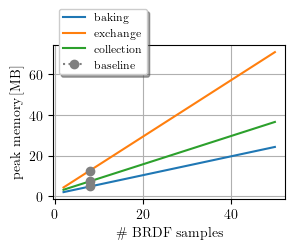

In [100]:
runtime = np.array(dat["brdf_resolution"]["t"])[:,1:]
data = np.array(dat["brdf_resolution"]["data"])
memory = np.array(dat["brdf_resolution"]["mem"])[:,1:,1]/1000**2

# get number of samples used
num=[]
for dd in data:
    samples = pf.samplings.sph_gaussian(dd)
    num.append(samples[np.where((samples.elevation*180/np.pi >= 0))].cshape[0])

num=np.array(num)

# find baseline
i = np.argwhere(data==dat["baseline"]["brdf_resolution"])[0]
# get total runtime
ssum = np.sum(runtime,axis=1)

fn,a=create_fig()
plt.plot(num,runtime)
# plot total runtime
plt.plot(num,np.sum(runtime,axis=1),'--')
# plot baseline
plt.plot(num[i]*np.ones((len(runtime.T[:,i])+1)),
         np.append(runtime.T[:,i],ssum[i]),
         'o:', color='gray')
plt.xlabel("\\# BRDF samples")
plt.ylabel(tlabel)
plt.legend(tlegend,fontsize=8,loc="upper left",
           bbox_to_anchor=(0, 1.27),shadow=True)
plt.show()

export_fig(fn,filename="Figure15a")



fmn,a=create_fig()
plt.plot(num,memory)
# plot baseline
plt.plot(num[i]*np.ones_like(memory.T[:,i]),memory.T[:,i],
         'o:', color='gray')
plt.xlabel("\\# BRDF samples")
plt.ylabel(mlabel)
plt.legend(mlegend,fontsize=8,loc="upper left",
           bbox_to_anchor=(0, 1.27),shadow=True)
plt.show()

export_fig(fmn,filename="Figure15b")


### max. reflection order

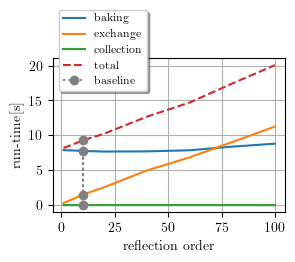

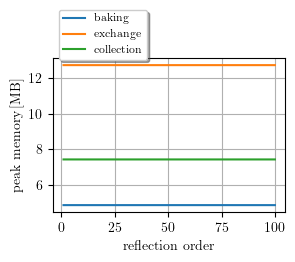

In [101]:
runtime = np.array(dat["reflection_order"]["t"])[:,1:]
data = np.array(dat["reflection_order"]["data"])
memory = np.array(dat["reflection_order"]["mem"])[:,1:,1]/1000**2

# find baseline
i = np.argwhere(data==dat["baseline"]["reflection_order"])[0]
# get total runtime
ssum = np.sum(runtime,axis=1)


f,a=create_fig()
plt.plot(data,runtime)
# plot total runtime
plt.plot(data,np.sum(runtime,axis=1),'--')
# plot baseline
plt.plot(data[i]*np.ones((len(runtime.T[:,i])+1)),
         np.append(runtime.T[:,i],ssum[i]),
         'o:', color='gray')
plt.xlabel("reflection order")
plt.ylabel(tlabel)
plt.legend(tlegend,fontsize=8,loc="upper left",
           bbox_to_anchor=(0, 1.35),shadow=True)

plt.show()

export_fig(f,filename="Figure14a")

fm,a=create_fig()
plt.plot(data,memory)
plt.xlabel("reflection order")
plt.ylabel(mlabel)
plt.legend(mlegend,fontsize=8,loc="upper left",
           bbox_to_anchor=(0, 1.35),shadow=True)
plt.show()

export_fig(fm,filename="Figure14b")

### patch resolution

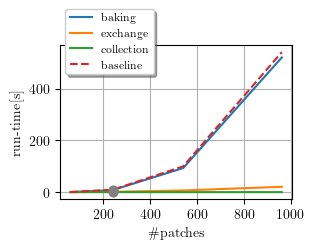

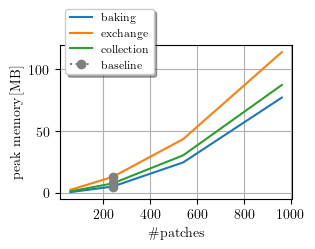

In [102]:
runtime = np.array(dat["patch_size"]["t"])[:,1:]
data = np.array(dat["patch_size"]["data"])
memory = np.array(dat["patch_size"]["mem"])[:,1:,1]/1000**2
num = (6*2+12)*90/data**2

num=np.array(num)
# find baseline
i = np.argwhere(data==dat["baseline"]["patch_size"])[0]
# get total runtime
ssum = np.sum(runtime,axis=1)


fn,a=create_fig()
plt.plot(num,runtime)
# plot total runtime
plt.plot(num,np.sum(runtime,axis=1),'--')
# plot baseline
plt.plot(num[i]*np.ones((len(runtime.T[:,i])+1)),
         np.append(runtime.T[:,i],ssum[i]),
         'o:', color='gray')
plt.xlabel("\\#patches")
plt.ylabel(tlabel)
plt.legend(mlegend,fontsize=8,loc="upper left",
           bbox_to_anchor=(0, 1.27),shadow=True)
plt.show()

export_fig(fn,filename="Figure16a")

fm,a=create_fig()
plt.plot(num,memory)
# plot baseline
plt.plot(num[i]*np.ones_like(memory.T[:,i]),memory.T[:,i],
         'o:', color='gray')
plt.xlabel("\\#patches")
plt.ylabel(mlabel)
plt.legend(mlegend,fontsize=8,loc="upper left",
           bbox_to_anchor=(0, 1.27),shadow=True)
plt.show()

export_fig(fm,filename="Figure16b")